In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install pandas
# !pip install pydicom

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import os
import pydicom

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

https://www.kaggle.com/seraphwedd18/pe-detection-with-keras-model-creation#Training-Model

In [2]:
train_path = 'E:\\Download\\new_downloads\\train'
csv_path = 'E:\\Download\\new_downloads\\train.csv'
sample_subm_csv_path = 'E:Download\\new_downloads\\sample_submission.csv'

In [3]:
df_train = pd.read_csv(csv_path)

In [4]:
df_train.shape

(1790594, 17)

In [5]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [6]:
df_train.tail()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1790589,4833c9b6a5d0,57e3e3c5f910,da0ecef50cf5,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790590,4833c9b6a5d0,57e3e3c5f910,d74b46c2f2c4,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790591,4833c9b6a5d0,57e3e3c5f910,ba71189191ad,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790592,4833c9b6a5d0,57e3e3c5f910,f4fdc88f2ace,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790593,4833c9b6a5d0,57e3e3c5f910,f890efd48940,1,0,0,0,0,0,1,1,1,0,0,0,0,0


In [7]:
sample_csv_df = pd.read_csv(sample_subm_csv_path)

In [8]:
sample_csv_df.shape

(152703, 2)

In [9]:
sample_csv_df.head()

,id,label
0,df06fad17bc3_negative_exam_for_pe,0.5
1,c8039e7f9e63_negative_exam_for_pe,0.5
2,761f6f1a9f5b_negative_exam_for_pe,0.5
3,c8db5b1f6b56_negative_exam_for_pe,0.5
4,462e805da1f1_negative_exam_for_pe,0.5


In [44]:
def read_an_image(image_path):
    '''
    read a .dcm image and convert it to a float numpy array
    '''
    mri_file = open(image_path, 'rb')
    dcm_im = pydicom.read_file(mri_file)
    image_2d = dcm_im.pixel_array.astype(float)
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max())
    return image_2d_scaled.astype(np.float32)

def get_an_image(df, idx=0):
        sample_img_path = os.path.join(train_path, df.iloc[idx][0], df.iloc[idx][1], df.iloc[idx][2])+'.dcm'
        img = read_an_image(sample_img_path)
        print('Reading image:', sample_img_path)
        return img

def get_a_random_image(df):
    while True:
        rand_idx = np.random.randint(len(df))
        try:
            img = get_an_image(df, rand_idx)
            print(rand_idx)
#             print('getting image with id ', rand_idx)
            return img
            
        except:
            pass

In [14]:
img = get_a_random_image(df_train)

Reading image: E:\Download\new_downloads\train\5b47dd837b28\2d83e8a0c0e4\2d22c0c910c9.dcm


In [15]:
img.shape, img.min(), img.max()

((512, 512), 0.0, 1.0)

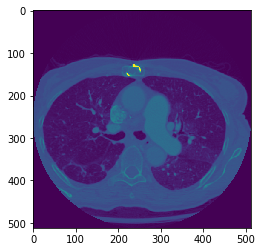

In [16]:
plt.imshow(img)

In [62]:
class LungsDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        img = get_an_image(self.csv_file, idx)
        target = df_train.iloc[idx,3:].to_numpy()

        if self.transform:
            img = self.transform(img)

        return img, target, idx

In [63]:
train_dataset = LungsDataset(df_train)

len(train_dataset)

1790594

In [67]:
for i in range(len(train_dataset)):
    try:
#         rand_idx = np.random.randint(len(df_train))
        sample, target, idx = train_dataset[i]
        break
    except:
        print('Error getting image!', i)

Error getting image! 0
Error getting image! 1
Error getting image! 2
Error getting image! 3
Error getting image! 4
Error getting image! 5
Error getting image! 6
Error getting image! 7
Error getting image! 8
Error getting image! 9
Error getting image! 10
Error getting image! 11
Error getting image! 12
Error getting image! 13
Error getting image! 14
Error getting image! 15
Error getting image! 16
Error getting image! 17
Error getting image! 18
Error getting image! 19
Error getting image! 20
Error getting image! 21
Error getting image! 22
Error getting image! 23
Error getting image! 24
Error getting image! 25
Error getting image! 26
Error getting image! 27
Error getting image! 28
Error getting image! 29
Error getting image! 30
Error getting image! 31
Error getting image! 32
Error getting image! 33
Error getting image! 34
Error getting image! 35
Error getting image! 36
Error getting image! 37
Error getting image! 38
Error getting image! 39
Error getting image! 40
Error getting image! 41
Er

In [68]:
sample, target, idx

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object),
 952)